In [28]:
import torch
import timm
m = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0, global_pool='')
print(m.pretrained_cfg)
o = m(torch.randn(2, 3, 224, 224))
print(f'Unpooled shape: {o.shape}')

B, C, W, H = o.shape

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth', 'hf_hub_id': 'timm/efficientnet_b0.ra_in1k', 'architecture': 'efficientnet_b0', 'tag': 'ra_in1k', 'custom_load': False, 'input_size': (3, 224, 224), 'fixed_input_size': False, 'interpolation': 'bicubic', 'crop_pct': 0.875, 'crop_mode': 'center', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'num_classes': 1000, 'pool_size': (7, 7), 'first_conv': 'conv_stem', 'classifier': 'classifier'}
Unpooled shape: torch.Size([2, 1280, 7, 7])


In [32]:
from urllib.request import urlopen
from PIL import Image
import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model(
    'vit_base_patch16_224.augreg2_in21k_ft_in1k',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)
model = model.eval()

o = torch.rand((2, 3, 224, 224))

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)

print(data_config)

transforms = timm.data.create_transform(**data_config, is_training=False)

print(transforms)

output = model(o)  # output is (batch_size, num_features) shaped tensor

# or equivalently (without needing to set num_classes=0)

output = model.forward_features(transforms(img).unsqueeze(0))
# output is unpooled, a (1, 197, 768) shaped tensor

print(output[0, 0, :10])

output = model.forward_head(output, pre_logits=True)
# output is a (1, num_features) shaped tensor

print(output[0, :10])

{'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'crop_pct': 0.9, 'crop_mode': 'center'}
Compose(
    Resize(size=248, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
)
tensor([ 0.7394,  0.3162, -0.3828, -0.3556, -3.3390, -1.3829, -1.5910, -1.0768,
         0.9661, -1.3756], grad_fn=<SliceBackward0>)
tensor([ 0.7394,  0.3162, -0.3828, -0.3556, -3.3390, -1.3829, -1.5910, -1.0768,
         0.9661, -1.3756], grad_fn=<SliceBackward0>)


In [74]:
from pathlib import Path
from PIL import Image
from IPython.display import display
import pandas as pd

jpeg_p = Path("jpegs_small")
mask_p = Path("masks_small")

df = pd.DataFrame(columns=['masks', 'label'])

X = []
Y = []

dt = 4 # Past images
dl = 1 # Future images to predict

for folder in mask_p.glob("*/*"):
    imgs = list(folder.glob("*"))
    for i in range(len(imgs) - dt - dl + 1):
        # img = imgs[img]
        # print(img)
        # img_mask = mask_p / Path(*img.parts[1:])
        # print(img_mask)
        # display(Image.open(img))
        # display(Image.open(img_mask))
        x = ",".join(str(img) for img in imgs[i: i+dt])
        y = imgs[i + dt + dl - 1]
        X.append(x)
        Y.append(y)

new_row = pd.DataFrame({'masks': X, 'label': Y})    
df = pd.concat([df, new_row], ignore_index=True)
df.to_csv('training.csv', index=False)

inputs


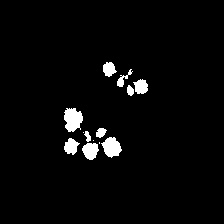

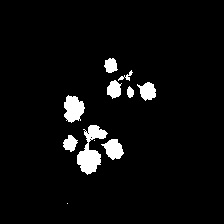

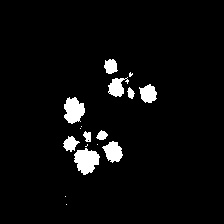

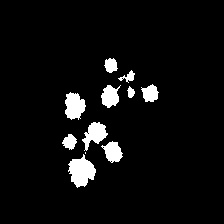

output


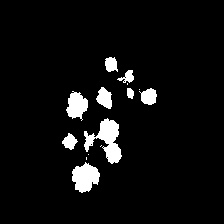

In [79]:
df = pd.read_csv("training.csv")

x, y = df.iloc[40]

print("inputs")
for i in x.split(","):
    display(Image.open(i))

print("output")
display(Image.open(y))



In [80]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import albumentations as a
from pathlib import Path


class CustomDataset(Dataset):
    def __init__(self, dt, dl, masks_p):
        
        

ModuleNotFoundError: No module named 'albumentations'